In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [3]:
DATA_PATH = 'data_dirty/train/images/'
LAND_PATH = 'data_dirty/train/landmarks.csv'

IMAGE_PATHS = np.array([os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH)])
LANDMARKS = pd.read_csv(LAND_PATH, sep='\t').set_index('file_name')

In [4]:
def show_image(file, title, rad=1, ax=None):
    src = cv2.imread(DATA_PATH + file)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    landmark = LANDMARKS.loc[file, :].values.reshape(971, 2)
    for i, (x, y) in enumerate(landmark):
        cv2.circle(src, (int(x), int(y)), rad, (0, 255, 0), -1)
        
    ax = ax or plt.gca()
    ax.set_title(title)
    ax.imshow(src)

In [5]:
def angle_variation(ps):
    dps = np.diff(ps, axis=0)
    angles = []
    for i in range(len(dps) - 1):
        e1, e2 = dps[i], dps[i+1]
        x = np.clip(e1.dot(e2)/(np.linalg.norm(e1) * np.linalg.norm(e2) + 0.00001), -1, 1)
        angle = math.acos(x)*180/math.pi
        angles.append(angle)

    return np.mean(angles)

In [6]:
stats = []

for image in tqdm(IMAGE_PATHS):
    img_file = image.split('/')[-1]
    img_landmark = LANDMARKS.loc[img_file].values.reshape(971, 2)
    stat1 = angle_variation(img_landmark[:64,:])
    stat2 = angle_variation(img_landmark[64:128,:])
    stats.append((img_file, stat1, stat2))

stats = np.array(stats)
stats = pd.DataFrame({'file': stats[:,0], 
                      'stat1': stats[:, 1].astype(float), 
                      'stat2': stats[:, 2].astype(float)})

100%|██████████| 64000/64000 [04:18<00:00, 247.88it/s]


In [7]:
smooth = stats[(stats['stat1'] < 40) & (stats['stat2'] < 40)].reset_index()
noisy = stats[(stats['stat1'] > 70) & (stats['stat2'] > 70)].reset_index()

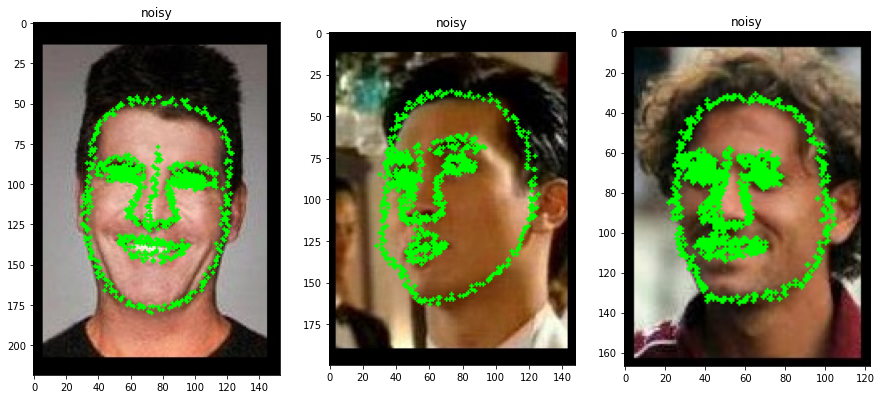

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

show_image(noisy['file'].values[0], title='noisy', rad=1, ax=axes[0])
show_image(noisy['file'].values[1], title='noisy', rad=1,ax=axes[1])
show_image(noisy['file'].values[2], title='noisy', rad=1,ax=axes[2])

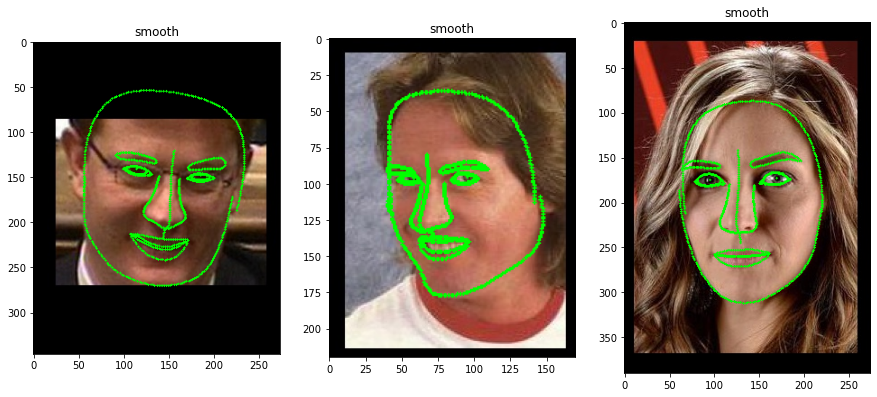

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

show_image(smooth['file'].values[0], title='smooth', rad=1, ax=axes[0])
show_image(smooth['file'].values[1], title='smooth', rad=1,ax=axes[1])
show_image(smooth['file'].values[2], title='smooth', rad=1,ax=axes[2])

In [9]:
noisy['file'].values

array(['f590c9a55420a385fd868c84de8de835.jpg',
       'b6d97579379d7c8aec01168b0c7e9fc8.jpg',
       'a9f354ef8be7836fd1560501edbd2b2e.jpg', ...,
       '25ad81dcf9ade3afe85be4ab98332116.jpg',
       'bd5340a4178e2a5a59deccb21eaef4c3.jpg',
       '18678f9ce6a26525a7a6fb3beca9e086.jpg'], dtype=object)

In [12]:
noisy.to_csv('noisy_images.csv')